In [10]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from html_table_parser import HTMLTableParser
import numpy as np


def clean_closed_blocks_cell(s):
    m,M = s.split(' - ')
    return ((int(m)-1) + (int(M))-1) / 2
    
def clean_df(df):
    df['closed blocks'] = [clean_closed_blocks_cell(x) for x in df['closed blocks']]
    return df

# when runs are split into multiple files due to computation constraints
def load_folder(folder_path, table_idxs=None):
    results_dfs = []
    html_parser = HTMLTableParser()
    if not table_idxs: table_idxs = 0 # default
    for fname in folder_path.glob('*.html'):
        table = html_parser.parse_url(str(fname), spec_indices=table_idxs)
        results_dfs += [clean_df(df) for (i,df) in table]
    return pd.concat(results_dfs)

n_nodes_keyname = '# Nodes'
m_keyname = '# Committee Members'
k_keyname= 'threshold size'
byz_keyname = '# Byzantine'
bw_node_keyname = 'BW per node (Mbits/sec)'
etx_size_keyname = 'etx size (bytes)'
num_etx_per_block_keyname = 'number of etxs / block'
num_closed_keyname = 'closed blocks'
tx_thrghpt_keyname = 'num_tx_sec'
timelimit_keyname = 'proposal time limit'
latency_keyname = 'block_latency'
    
url = Path("oa-benchmark-output/oa-happy-flow-bw-1")


node_bws = [1000, 500, 100]
etx_size = 250
threshold_factor = 1
sim_time_limit_sec = 100
proposal_time_limit = 10000

In [11]:
tables_to_display = [ 0 ] # out of all tables on benchmark page (0,1,..)
results_df = load_folder(url, table_idxs=tables_to_display)
# find throughput , latency
results_df[tx_thrghpt_keyname] = results_df[num_etx_per_block_keyname] * results_df[num_closed_keyname] / sim_time_limit_sec
results_df[latency_keyname] =  sim_time_limit_sec / results_df[num_closed_keyname]
color_idx = np.linspace(0, 1, len(results_df[m_keyname].unique()))

<IPython.core.display.Javascript object>


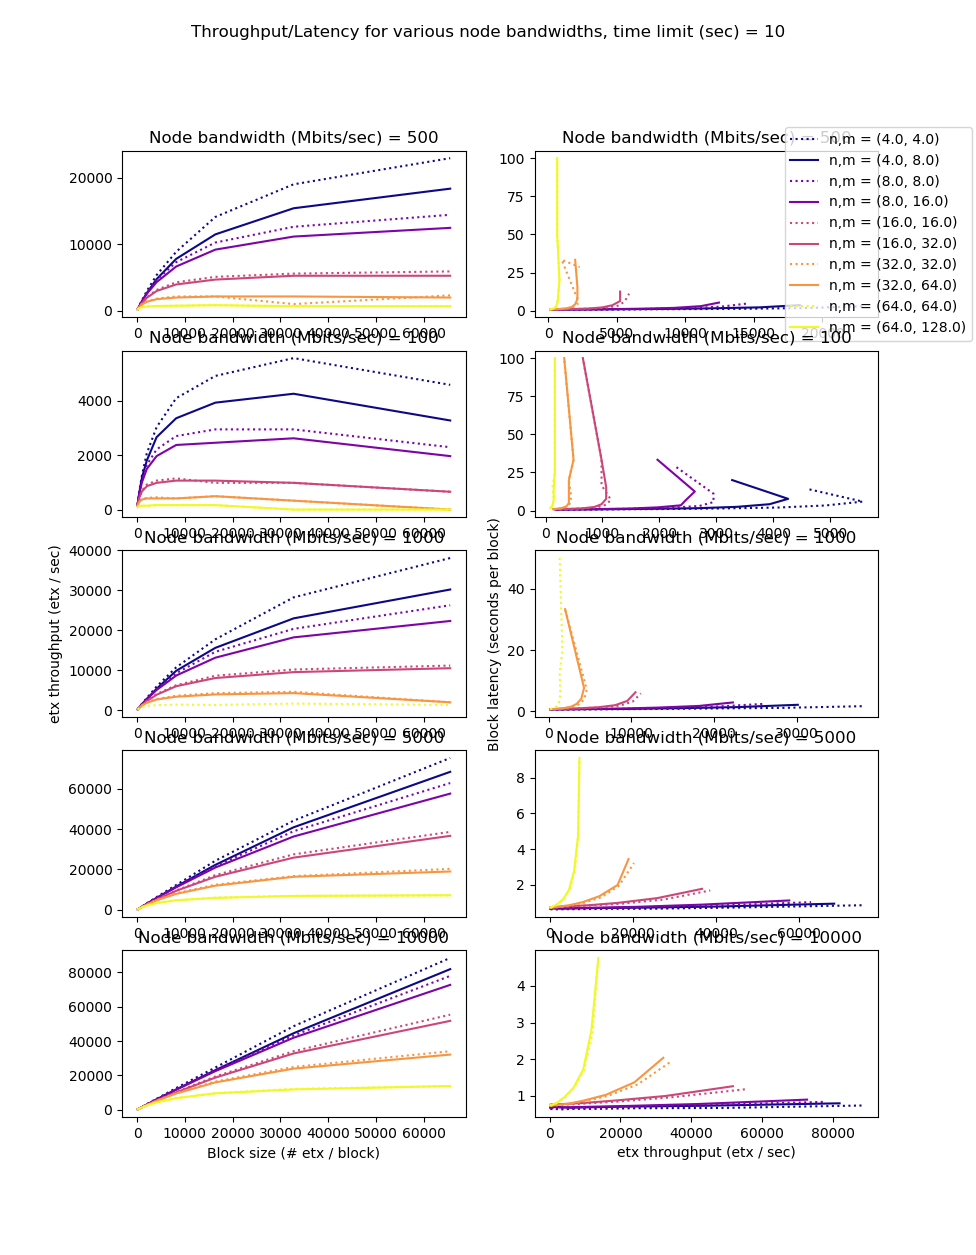

Text(0.5,0.98,'Throughput/Latency for various node bandwidths, time limit (sec) = 10')

In [17]:
bws = results_df[bw_node_keyname].unique()
fig, ax = plt.subplots(len(bws), 2)

for i,bw in enumerate(bws):
        
        query_df = results_df[(results_df[bw_node_keyname] == bw) & (results_df[etx_size_keyname] == etx_size) & (results_df[k_keyname] == (results_df[byz_keyname] * threshold_factor + 1)) & (results_df[timelimit_keyname] == proposal_time_limit) ]
        
        groups_m = query_df.groupby([m_keyname, n_nodes_keyname])
        
        
        # plot throughput as function of block size
        legend = []
        ax[int(len(bws))-1,0].set_xlabel('Block size (# etx / block)')
        ax[int(len(bws)/2),0].set_ylabel('etx throughput (etx / sec)')
        ax[i,0].set_title('Node bandwidth (Mbits/sec) = %d' % (bw))
        for j,(name, g) in enumerate(groups_m):
            legend.append('n,m = %s' %(str(name)))
            c = j // 2
            s = [':','-'][(j % 2)]
            ax[i,0].plot(g[num_etx_per_block_keyname], g[tx_thrghpt_keyname], color=plt.cm.plasma(color_idx[c]), linestyle=s)
        
        # plot block latency as function of throughput
        legend = []
        ax[int(len(bws))-1,1].set_xlabel('etx throughput (etx / sec)')
        ax[int(len(bws)/2),1].set_ylabel('Block latency (seconds per block)')
        ax[i,1].set_title('Node bandwidth (Mbits/sec) = %d' % (bw))
        for j,(name, g) in enumerate(groups_m):
            c = j // 2
            s = [':','-'][(j % 2)]
            legend.append('n,m = %s' %(str(name)))
            ax[i,1].plot(g[tx_thrghpt_keyname], g[latency_keyname], color=plt.cm.plasma(color_idx[c]), linestyle=s)
            if i == 0:
                ax[i,1].legend(legend, loc='center', bbox_to_anchor=(1, 0.5))

fig.suptitle('Throughput/Latency for various node bandwidths, time limit (sec) = %d' %(proposal_time_limit / 1000))

<IPython.core.display.Javascript object>


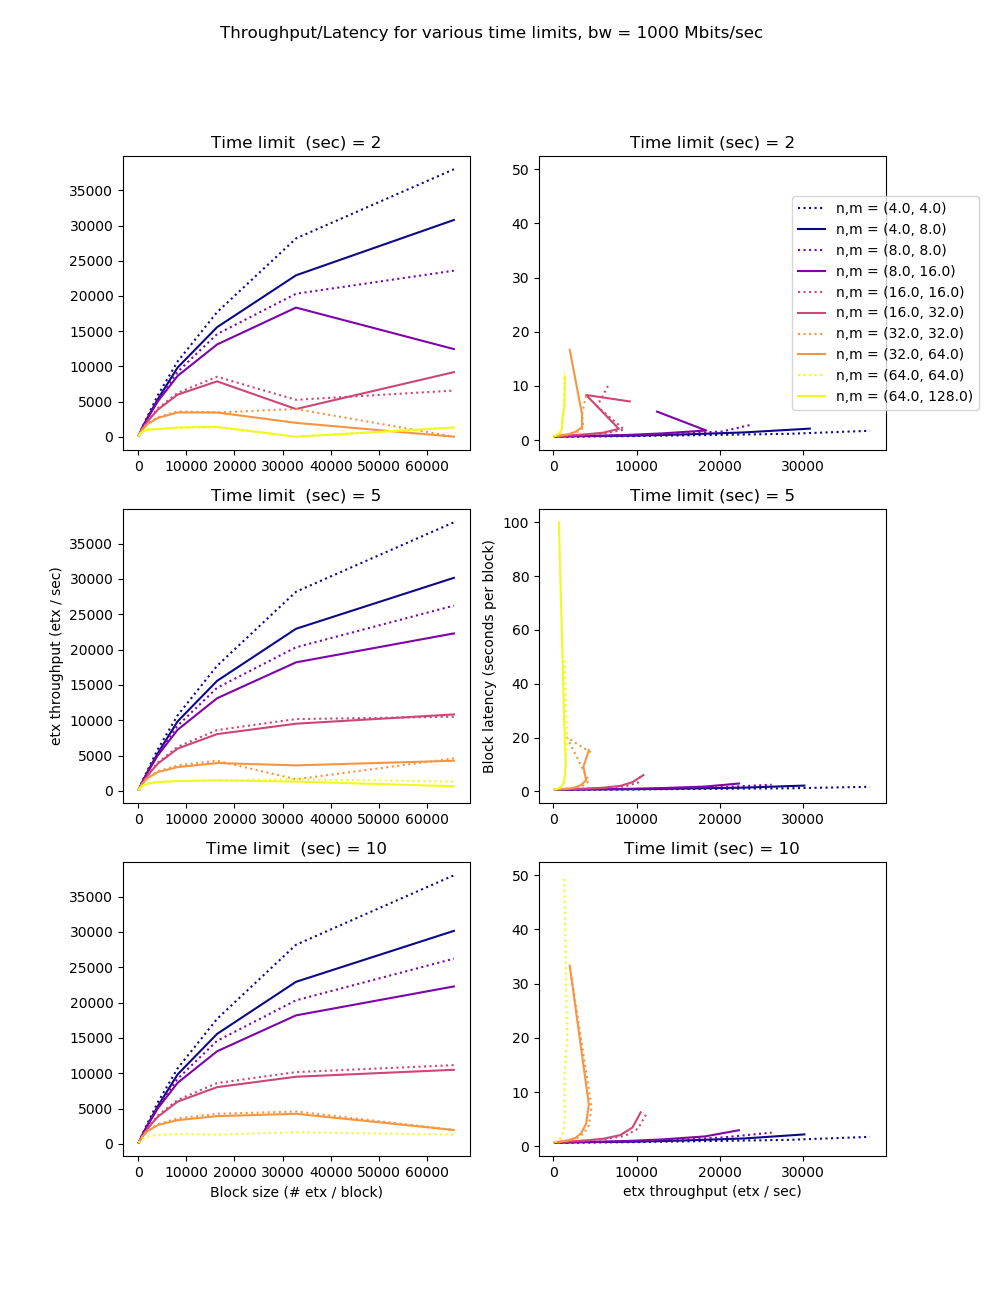

Text(0.5,0.98,'Throughput/Latency for various time limits, bw = 1000 Mbits/sec')

In [19]:
times = [2000,5000,10000]
bw = 1000
fig, ax = plt.subplots(len(times), 2)

for i,tl in enumerate(times):
        
        query_df = results_df[(results_df[timelimit_keyname] == tl) & (results_df[etx_size_keyname] == etx_size) & (results_df[k_keyname] == (results_df[byz_keyname] * threshold_factor + 1)) & (results_df[bw_node_keyname] == bw)]
        
        groups_m = query_df.groupby([m_keyname, n_nodes_keyname])
        
        # plot throughput as function of block size
        legend = []
        ax[int(len(times))-1,0].set_xlabel('Block size (# etx / block)')
        ax[int(len(times)/2),0].set_ylabel('etx throughput (etx / sec)')
        ax[i,0].set_title('Time limit  (sec) = %d' % (tl / 1000))
        for j,(name, g) in enumerate(groups_m):
            c = j // 2
            s = [':','-'][(j % 2)]
            legend.append('n,m = %s' %(str(name)))
            ax[i,0].plot(g[num_etx_per_block_keyname], g[tx_thrghpt_keyname], color=plt.cm.plasma(color_idx[c]), linestyle=s)

        
        # plot block latency as function of throughput
        legend = []
        ax[int(len(times))-1,1].set_xlabel('etx throughput (etx / sec)')
        ax[int(len(times)/2),1].set_ylabel('Block latency (seconds per block)')
        ax[i,1].set_title('Time limit (sec) = %d' % (tl / 1000))
        for j,(name, g) in enumerate(groups_m):
            c = j // 2
            s = [':','-'][(j % 2)]
            legend.append('n,m = %s' %(str(name)))
            ax[i,1].plot(g[tx_thrghpt_keyname], g[latency_keyname], color=plt.cm.plasma(color_idx[c]), linestyle=s)
            if i == 0:
                ax[i,1].legend(legend, loc='center', bbox_to_anchor=(1, 0.5))

            
fig.suptitle('Throughput/Latency for various time limits, bw = %d Mbits/sec' % (bw))